# K-Means

K-means is a simple unsupervised machine learning algorithm that groups data into a specified number (k) of clusters. The algorithm works iteratively to assign each data point to one of K clusters based on the features that are provided. Data points are clustered based on feature similarity.

## Setup

### Set Random State Seed

In [66]:
import random
import numpy as np

seed = 60
random.seed(seed)
np.random.seed(seed)

### Paths

In [67]:
from dataclasses import dataclass
import os


@dataclass
class Paths:
    root = os.path.dirname(os.path.dirname(os.path.abspath(".")))
    models_dir = os.path.join(root, "data", "models")
    model_name: str = "k_means"
    model_dir: str = os.path.join(models_dir, model_name)
    default_model: str = ""

    def __post_init__(self):
        assert os.path.exists(self.models_dir), f"Models directory not found at {self.models_dir}"

    @classmethod
    def avoir_overwrite(cls, path):
        index = 1
        while os.path.exists(path):
            path += f"_{index}"
            index += 1
        return path


paths = Paths()

## Load Dataset

In [68]:
from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Number of clusters

In [69]:
import numpy as np

n_clusters = len(np.unique(y_train))

print(n_clusters)

10


## Preprocessing

### Reshape

In [70]:
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

In [71]:
f"{x_train.shape = }, {x_test.shape = }"

'x_train.shape = (60000, 784), x_test.shape = (10000, 784)'

### Standardize

In [72]:
from sklearn.preprocessing import StandardScaler

x_train = StandardScaler().fit_transform(x_train)

## K-Means

### Implementation

In [73]:
import random
import numpy as np
from tqdm import tqdm
import pickle

class KMeans:
    def __init__(self, n_clusters: int, max_iter: int = 300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None

    @classmethod
    def __euclidean(cls, point, data):
        return np.sqrt(np.sum((point - data) ** 2, axis=1))

    def fit(self, X_train):
        self.centroids = [random.choice(X_train)]
        for _ in tqdm(range(self.n_clusters - 1)):
            dists = np.sum(
                [self.__euclidean(centroid, X_train) for centroid in self.centroids],
                axis=0,
            )
            dists /= np.sum(dists)
            (new_centroid_idx,) = np.random.choice(range(len(X_train)), size=1, p=dists)
            self.centroids += [X_train[new_centroid_idx]]

        iteration = 0
        prev_centroids = None
        while (
            np.not_equal(self.centroids, prev_centroids).any()
            and iteration < self.max_iter
        ):
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in tqdm(X_train):
                dists = self.__euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            prev_centroids = self.centroids
            self.centroids = [
                np.mean(cluster, axis=0) for cluster in sorted_points if cluster
            ]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():
                    self.centroids[i] = prev_centroids[i]
            iteration += 1

        self.__save(os.path.join(paths.model_dir, "model.pkl"))

    def evaluate(self, X):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = self.__euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return centroids, centroid_idxs

    def compress(self, X):
        _, centroid_idxs = self.evaluate(X)
        return np.array(centroid_idxs)

    def decompress(self, compressed_data):
        return np.array([self.centroids[idx] for idx in compressed_data])

    def generate(self, n_samples):
        if self.centroids is None:
            raise ValueError("Model must be fitted before generating samples.")

        generated_samples = []
        for _ in range(n_samples):
            # Randomly select a centroid
            centroid = random.choice(self.centroids)
            # Add some noise to create variation
            noise = np.random.normal(0, 0.1, size=centroid.shape)
            sample = centroid + noise
            generated_samples.append(sample)

        return np.array(generated_samples)

    @classmethod
    def __save(cls, filename: str):
        with open(filename, "wb") as f:
            pickle.dump(cls, f)

    @classmethod
    def load(cls, filename: str):
        with open(filename, "rb") as f:
            return pickle.load(f)

### Training

In [74]:
k_means = KMeans(n_clusters=n_clusters)
k_means.fit(x_train)

100%|██████████| 60000/60000 [00:01<00:00, 55311.70it/s]


## Data Vizuallization

In [75]:
import matplotlib.pyplot as plt

def plot_digits(images, title: str, n_rows: int = 3, n_cols: int = 3):
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    plt.suptitle(title, fontsize=16)
    for i, image in enumerate(images[:n_rows * n_cols]):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

### Original Images

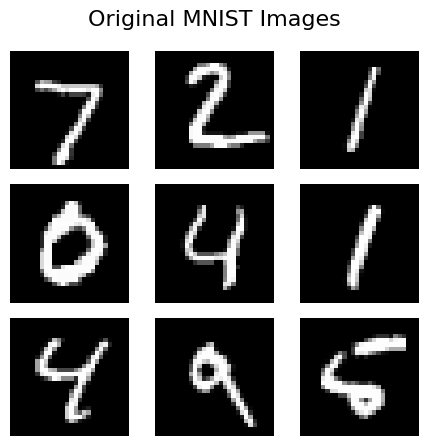

In [76]:
plot_digits(x_test, "Original MNIST Images")

### Compressed & Decompressed Images

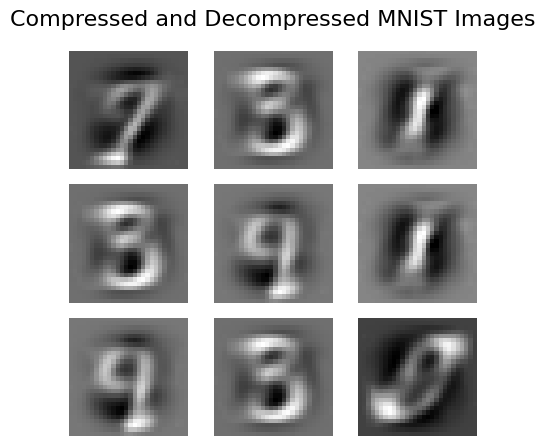

In [77]:
compressed_data = k_means.compress(x_test)
decompressed_data = k_means.decompress(compressed_data)
plot_digits(decompressed_data, "Compressed and Decompressed MNIST Images")

### Generation

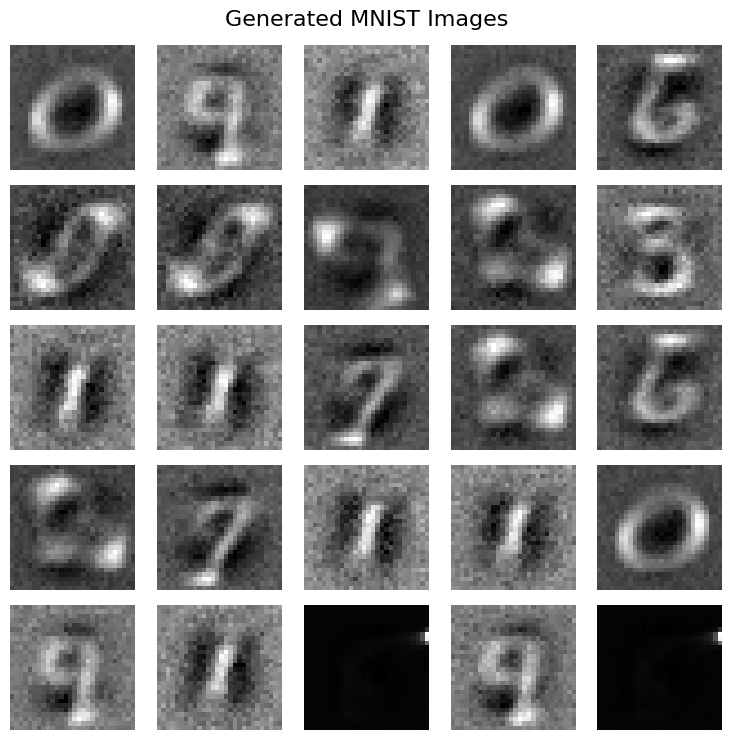

In [78]:
generated_samples = k_means.generate(n_samples=25)
plot_digits(generated_samples, "Generated MNIST Images", n_rows=5, n_cols=5)

### Latent Space Representation

In [79]:
latent_representation_centroid = k_means.compress(x_test)


def get_distance_representation(X):
    distances = np.array([k_means._KMeans__euclidean(x, k_means.centroids) for x in X])
    return distances


latent_representation_distance = get_distance_representation(x_test)

#### Centroid-Based

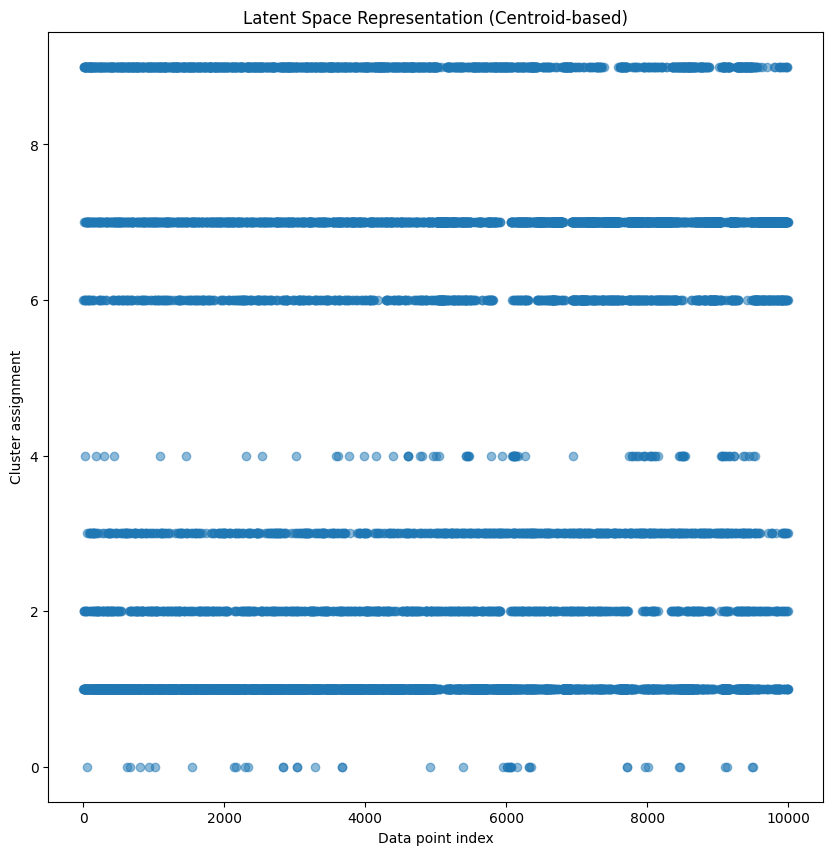

In [80]:
plt.figure(figsize=(10, 10))
plt.scatter(
    range(len(latent_representation_centroid)),
    latent_representation_centroid,
    alpha=0.5,
)
plt.xlabel("Data point index")
plt.ylabel("Cluster assignment")
plt.title("Latent Space Representation (Centroid-based)")
plt.show()

#### Distance-Based

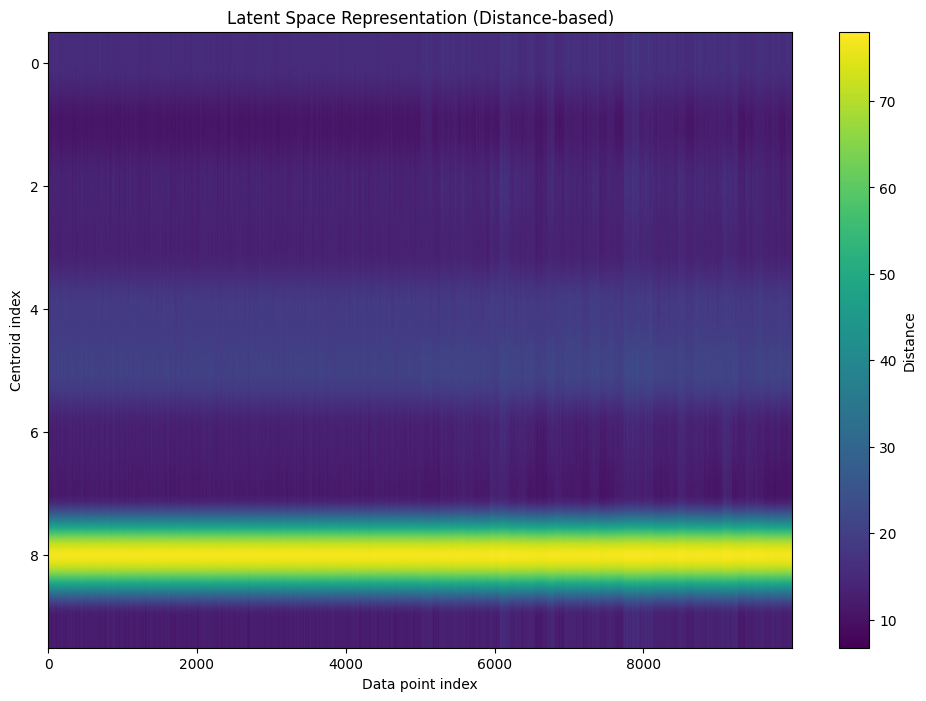

In [81]:
plt.figure(figsize=(12, 8))
plt.imshow(latent_representation_distance.T, aspect="auto", cmap="viridis")
plt.colorbar(label="Distance")
plt.xlabel("Data point index")
plt.ylabel("Centroid index")
plt.title("Latent Space Representation (Distance-based)")
plt.show()

#### Inter-Cluster Distance Heatmap

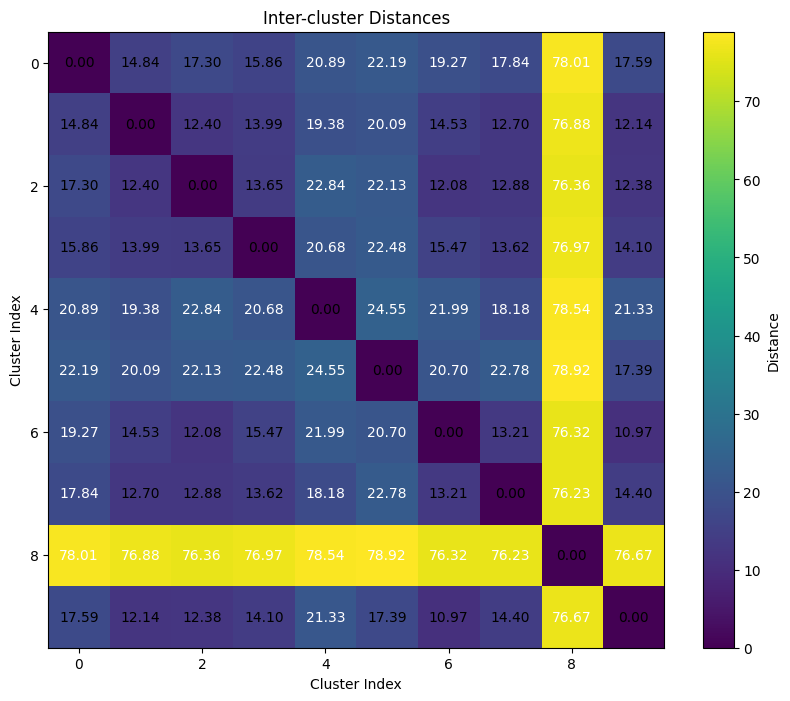

In [82]:
centroids_array = np.array(k_means.centroids)
centroid_distances = np.sqrt(
    ((centroids_array[:, None, :] - centroids_array[None, :, :]) ** 2).sum(axis=2)
)

plt.figure(figsize=(10, 8))
plt.imshow(centroid_distances, cmap="viridis")
plt.colorbar(label="Distance")
plt.title("Inter-cluster Distances")
plt.xlabel("Cluster Index")
plt.ylabel("Cluster Index")
for i in range(n_clusters):
    for j in range(n_clusters):
        plt.text(
            j,
            i,
            f"{centroid_distances[i, j]:.2f}",
            ha="center",
            va="center",
            color=(
                "white"
                if centroid_distances[i, j] > np.median(centroid_distances)
                else "black"
            ),
        )
plt.show()

#### Cluster Distribution

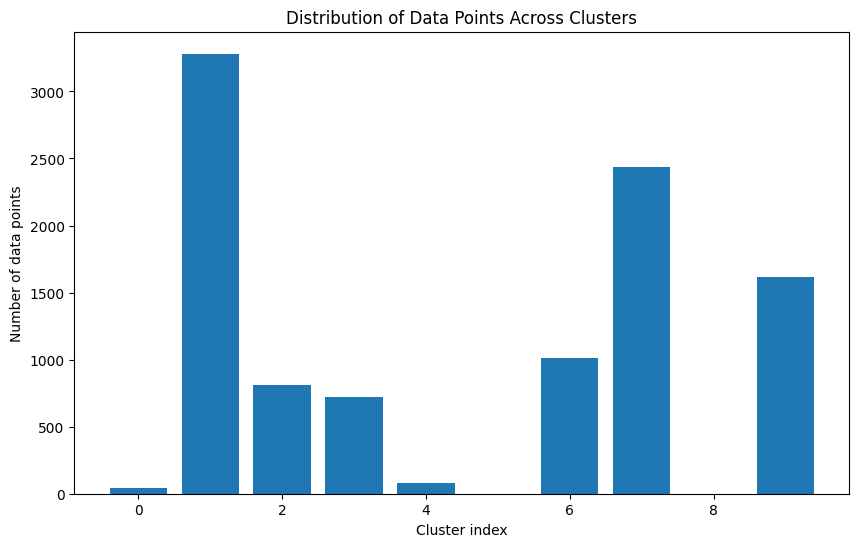

In [83]:
cluster_counts = np.bincount(latent_representation_centroid)
plt.figure(figsize=(10, 6))
plt.bar(range(n_clusters), cluster_counts)
plt.xlabel("Cluster index")
plt.ylabel("Number of data points")
plt.title("Distribution of Data Points Across Clusters")
plt.show()